In [1]:
# Imports
import os
import json
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from tangermeme.io import extract_loci
from tangermeme.predict import predict
from tangermeme.plot import plot_logo
from tangermeme.deep_lift_shap import deep_lift_shap
from bpnetlite.bpnet import ControlWrapper, CountWrapper, ProfileWrapper
from bpnetlite.performance import calculate_performance_measures
from bpnetlite.chrombpnet import BPNet

from weasyprint import HTML, CSS

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [54]:
path_evaluation = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation"

# Training curves

In [2]:
alpha = 6

In [3]:
# bias model
path_log = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/K562.bias.log"

In [4]:
# log dataframe
bias_log_df = pd.read_csv(path_log, sep="\t").drop_duplicates(subset="Epoch", keep="first")
bias_log_df["Training Loss"] = bias_log_df["Training MNLL"] + alpha*bias_log_df["Training Count MSE"]
bias_log_df["Validation Loss"] = bias_log_df["Validation MNLL"] + alpha*bias_log_df["Validation Count MSE"]
bias_log_df.head()

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?,Training Loss,Validation Loss
0,0,0,3.081924,4.638357,216.702850,18.638351,219.641678,0.146548,-0.083016,11.889074,True,328.532959,290.976124
32,1,3200,0.875983,4.525635,153.392090,0.646548,160.784027,0.405790,0.623615,0.690880,True,157.271379,164.929306
64,2,6400,1.747073,4.521678,153.425323,0.809450,160.424820,0.408205,0.697314,0.587702,False,158.282021,163.951033
96,3,9600,2.600977,4.519559,143.995819,1.364585,160.251785,0.408853,0.715799,0.701628,False,152.183328,164.461551
128,4,12800,3.454323,4.519546,149.421783,0.948719,160.155014,0.409781,0.727838,0.555521,False,155.114100,163.488137


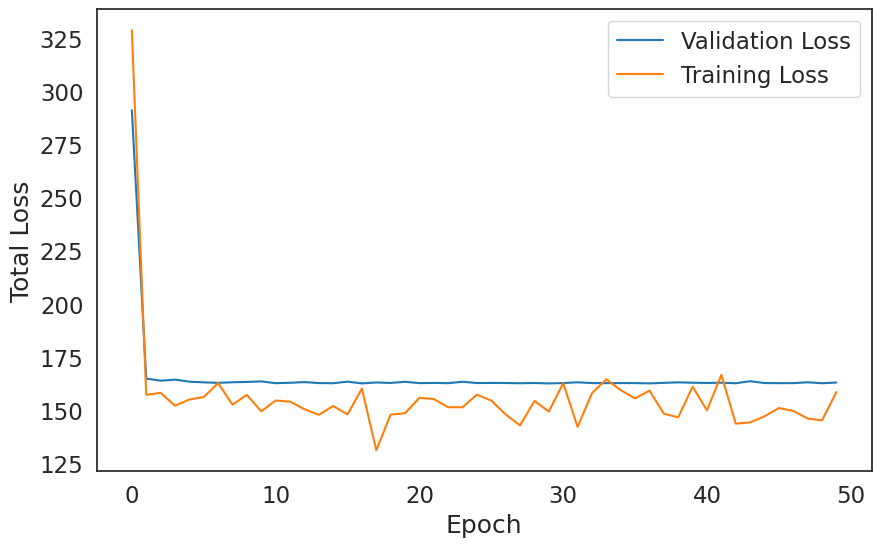

In [55]:
# Plot losses vs "Epoch"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Loss", label="Validation Loss")
    sns.lineplot(data=bias_log_df, x="Epoch", y="Training Loss", label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_loss.png", dpi=300)

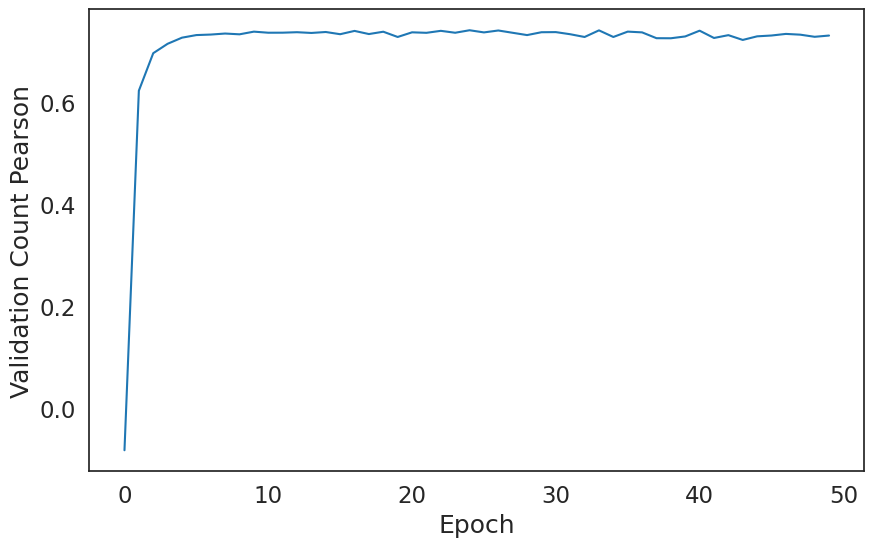

In [56]:
# Plot "Validation Count Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Count Pearson")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_val_count_pearson.png", dpi=300)

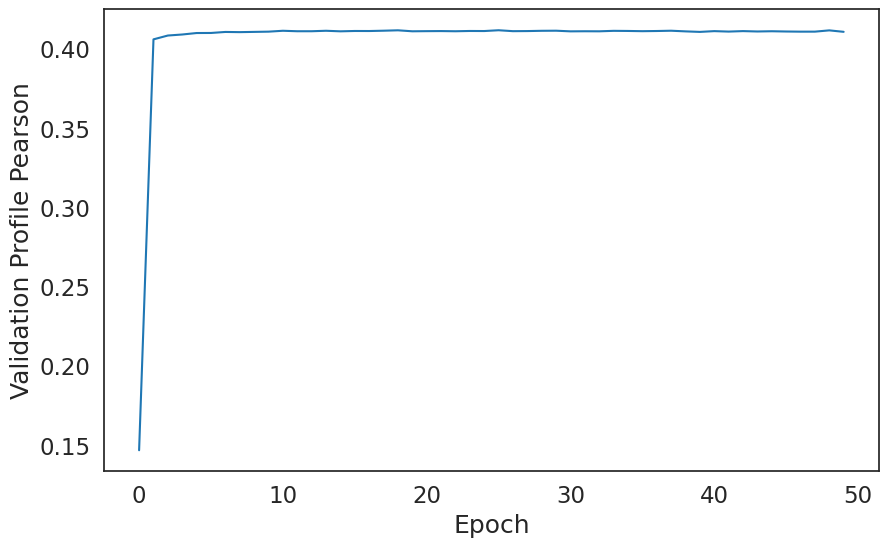

In [57]:
# Plot "Validation Profile Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Profile Pearson")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_val_profile_pearson.png", dpi=300)

# Load bias model

In [58]:
path_bias_model = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/K562.bias.torch"

In [59]:
# Load the model
if path_bias_model.endswith(".h5"):
    bias_model = BPNet.from_chrombpnet(path_bias_model).cuda().eval()
elif path_bias_model.endswith(".torch"):
    bias_model = torch.load(path_bias_model, map_location="cuda").eval()
bias_model

/tmp/ipykernel_1274950/4237501791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bias_model = torch.load(path_bias_model, map_location="cuda").eval()


BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Bias model performance

In [60]:
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

def scatter(
    x,
    y,
    ax=None,
    density=False,
    c="b",
    alpha=1,
    s=10,
    xlabel="Observed",
    ylabel="Predicted",
    figsize=(4, 4),
    save=None,
    add_reference_line=True,
    rasterized=False,
    return_axes=False,
):
    # Set up the axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Drop NA values if any
    x_nas = np.isnan(x)
    y_nas = np.isnan(y)
    x = x[~x_nas & ~y_nas]
    y = y[~x_nas & ~y_nas]

    if density:
        # Get point densities
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        c=z

    # Plot the points
    ax.scatter(x, y, c=c, s=s, rasterized=rasterized, alpha=alpha)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add scores
    r2 = r2_score(x, y)
    pearson_r = pearsonr(x, y)
    spearman_r = spearmanr(x, y)
    ax.annotate(f"R2: {r2:.3f}", (0.05, 0.95), xycoords="axes fraction")
    ax.annotate(f"Pearson: {pearson_r[0]:.3f}", (0.05, 0.90), xycoords="axes fraction")
    ax.annotate(f"Spearman: {spearman_r[0]:.3f}", (0.05, 0.85), xycoords="axes fraction")
    
    # Add y=x line for reference but make the mins and maxes extend past the data
    if add_reference_line:
        min_val = min(min(x), min(y))
        max_val = max(max(x), max(y))
        ax.plot([min_val, max_val], [min_val, max_val], c="k", ls="--", lw=1)
    
    # Plt
    plt.tight_layout()

    # Save
    if save:
        plt.savefig(save, dpi=300)
        plt.close()
    else:
        plt.show()

    if return_axes:
        return ax
    
def log_softmax_profile(
    y_profile,
):
    # Log softmax the predicted profile
    z = y_profile.shape
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y_profile = y_profile.reshape(*z)
    return y_profile

In [61]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
path_peaks = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/ENCSR868FGK_K562_ATAC-seq_peaks.bed"
path_negatives = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_negatives.bed"
path_signal = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_unstranded_counts.bw"
path_fa = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/hg38.fa"
path_splits = "/cellar/users/aklie/projects/ML4GLand/tutorials/data/splits/fold_0.json"
seq_len=2114

In [62]:
# Load test split
splits = json.load(open(path_splits, "r"))
chroms=splits["test"]
chroms

['chr1', 'chr3', 'chr6']

## Performance in peaks

In [99]:
recalculate_interval=True

In [100]:
# read peak
peak_df = pd.read_csv(path_peaks, sep="\t", header=None, names=NARROWPEAK_SCHEMA)
if recalculate_interval:
    peak_df["start"] = peak_df["start"] + peak_df["summit"] - seq_len // 2
    peak_df["end"] = peak_df["start"] + seq_len
peak_df = peak_df[peak_df["chr"].isin(chroms)]
print(f"Number of peak: {len(peak_df)}")

# extract peak
peak_seqs, peak_signals = extract_loci(
    peak_df,
    path_fa,
    signals=[path_signal],
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
)

# predict
peak_pred_profile, peak_predicted_counts = predict(model=bias_model, X=peak_seqs)

# log softmax
peak_pred_profile_probs = log_softmax_profile(peak_signals)

Number of peak: 66484


In [101]:
peak_counts = np.log(peak_signals.sum(axis=(1, 2)).cpu().detach().numpy() + 1)
peak_predicted_counts_np = peak_predicted_counts.squeeze().cpu().detach().numpy()
peak_counts.shape, peak_predicted_counts_np.shape

((66484,), (66484,))

In [102]:
scatter(
    peak_counts,
    peak_predicted_counts_np,
    xlabel="Log(raw counts+1)",
    ylabel="Predicted Log(raw counts+1)",
    add_reference_line=False,
    density=True,
    figsize=(8, 8),
    save=f"{path_evaluation}/K562.bias.peaks_pearsonr.png",
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3551257160.py, line 1)

In [103]:
peak_measures = calculate_performance_measures(
    peak_pred_profile_probs,
    peak_signals,
    peak_predicted_counts, 
    measures=['profile_mnll', 'profile_pearson', 'profile_jsd', 'count_mse', 'count_pearson', 'count_spearman']
)

In [104]:
# We want to shuffle along the target_length axis preserving the other axes for each sequence
shuffled_peak_signals = peak_signals.clone()
for i in range(shuffled_peak_signals.shape[0]):
    shuffled_peak_signals[i] = shuffled_peak_signals[i, :, torch.randperm(shuffled_peak_signals.shape[2])]

peak_shuffled_measures = calculate_performance_measures(
    peak_pred_profile_probs,
    shuffled_peak_signals,
    peak_predicted_counts, 
    measures=['profile_jsd']
)

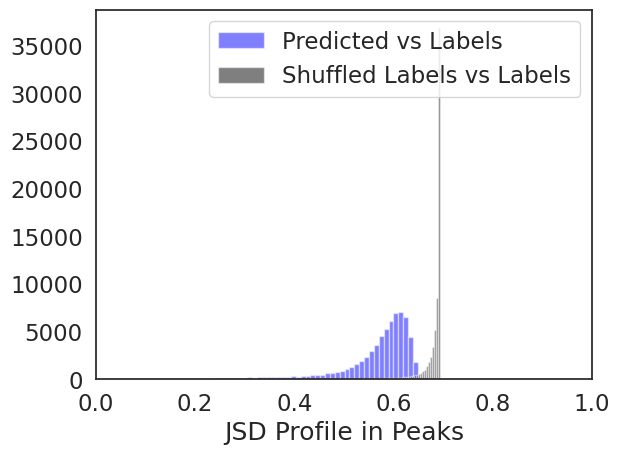

In [105]:
#plot jsd histogram
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure()
    n, bins, patches=plt.hist(peak_measures["profile_jsd"], 50, facecolor='blue', alpha=0.5, label="Predicted vs Labels")
    n1, bins1, patches1=plt.hist(peak_shuffled_measures["profile_jsd"], 50, facecolor='black', alpha=0.5,label='Shuffled Labels vs Labels')
    plt.xlim(0, 1)
    plt.xlabel('JSD Profile in Peaks')
    plt.legend(loc='best')
    plt.savefig(f"{path_evaluation}/K562.bias.peaks_jsd.png", dpi=300)

## Performance in negatives

In [106]:
recalculate_interval=False

In [107]:
# read negative
negative_df = pd.read_csv(path_negatives, sep="\t", header=None, names=NARROWPEAK_SCHEMA)
if recalculate_interval:
    negative_df["start"] = negative_df["start"] + negative_df["summit"] - seq_len // 2
    negative_df["end"] = negative_df["start"] + seq_len
negative_df = negative_df[negative_df["chr"].isin(chroms)]
print(f"Number of negative: {len(negative_df)}")

# extract negative
negative_seqs, negative_signals = extract_loci(
    negative_df,
    path_fa,
    signals=[path_signal],
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
)

# predict
negative_pred_signal, negative_predicted_counts = predict(model=bias_model, X=negative_seqs)

# log softmax
negative_pred_profile_probs = log_softmax_profile(negative_signals)

Number of negative: 40817


In [108]:
negative_counts = np.log(negative_signals.sum(axis=(1, 2)).cpu().detach().numpy() + 1)
negative_predicted_counts_np = negative_predicted_counts.squeeze().cpu().detach().numpy()
negative_counts.shape, negative_predicted_counts.shape

((40817,), torch.Size([40817, 1]))

In [73]:
scatter(
    negative_counts,
    negative_predicted_counts_np,
    xlabel="Log(raw counts+1)",
    ylabel="Predicted Log(raw counts+1)",
    add_reference_line=False,
    density=True,
    figsize=(8, 8),
    save=f"{path_evaluation}/K562.bias.negatives_pearsonr.png",
)

In [109]:
# We want to shuffle along the target_length axis preserving the other axes for each sequence
shuffled_negative_signals = negative_signals.clone()
for i in range(shuffled_negative_signals.shape[0]):
    shuffled_negative_signals[i] = shuffled_negative_signals[i, :, torch.randperm(shuffled_negative_signals.shape[2])]

negative_measures = calculate_performance_measures(
    negative_pred_profile_probs,
    negative_signals,
    negative_predicted_counts, 
    measures=['profile_mnll', 'profile_pearson', 'profile_jsd', 'count_mse', 'count_pearson', 'count_spearman']
)

In [110]:
# We want to shuffle along the target_length axis preserving the other axes for each sequence
shuffled_negative_signals = negative_signals.clone()
for i in range(shuffled_negative_signals.shape[0]):
    shuffled_negative_signals[i] = shuffled_negative_signals[i, :, torch.randperm(shuffled_negative_signals.shape[2])]

negative_shuffled_measures = calculate_performance_measures(
    negative_pred_profile_probs,
    shuffled_negative_signals,
    negative_predicted_counts, 
    measures=['profile_jsd']
)

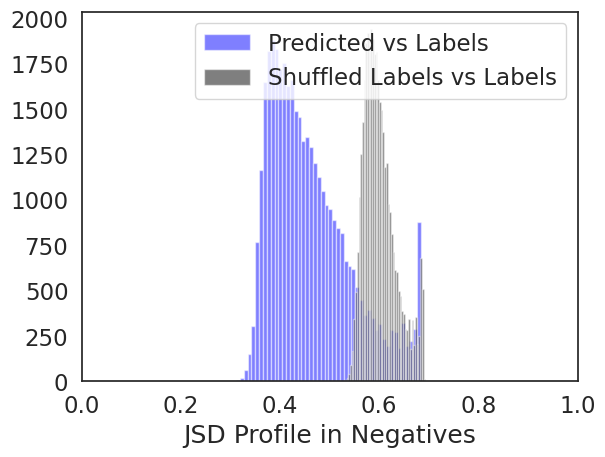

In [111]:
# plot jsd histogram
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure()
    n, bins, patches=plt.hist(negative_measures["profile_jsd"], 50, facecolor='blue', alpha=0.5, label="Predicted vs Labels")
    n1, bins1, patches1=plt.hist(negative_shuffled_measures["profile_jsd"], 50, facecolor='black', alpha=0.5,label='Shuffled Labels vs Labels')
    plt.xlim(0, 1)
    plt.xlabel('JSD Profile in Negatives')
    plt.legend(loc='best')
    plt.savefig(f"{path_evaluation}/K562.bias.negatives_jsd.png", dpi=300)

## Overall performance

In [112]:
metrics = {
    "counts_metrics": {
        "negatives": {
            "spearmanr": float(negative_measures["count_spearman"].item()),
            "pearsonr": float(negative_measures["count_pearson"].item()),
            "mse": float(negative_measures["count_mse"].item())
        },
        "peaks": {
            "spearmanr": float(peak_measures["count_spearman"].item()),
            "pearsonr": float(peak_measures["count_pearson"].item()),
            "mse": float(peak_measures["count_mse"].item())
        },
        "profile_metrics": {
            "negatives": {
                "median_jsd": float(np.nanmedian(negative_measures["profile_jsd"])),
                "median_shuffled_jsd": float(np.nanmedian(negative_shuffled_measures["profile_jsd"]))
            },
            "peaks": {
                "median_jsd": float(np.nanmedian(peak_measures["profile_jsd"])),
                "median_shuffled_jsd": float(np.nanmedian(peak_shuffled_measures["profile_jsd"]))
            }
        }
    }
}

In [113]:
import json
with open(f"{path_evaluation}/K562.bias.metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Contribution scores from bias model using `bpnet-lite`

In [21]:
path_subsample_peaks = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/auxiliary/K562_30K_subsample_peaks.bed"
path_out = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample"

In [22]:
X = extract_loci(
    loci=path_subsample_peaks,
    sequences=path_fa,
    max_jitter=0,
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    verbose=True,
)
X.shape

Loading Loci: 100%|██████████| 30000/30000 [00:06<00:00, 4896.75it/s]


torch.Size([30000, 4, 2114])

In [23]:
X = X[X.sum(dim=(1, 2)) == X.shape[-1]]
X.shape

torch.Size([29997, 4, 2114])

In [24]:
np.savez_compressed(os.path.join(path_out, "ohe"), X)

```bash
profile_json=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_attribute_profile.json
counts_json=/celljson=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_attribute_counts.json
bpnet attribute -p $profile_json
bpnet attribute -p $counts_json
```

# TF-modisco motifs

In [26]:
def convert_html_to_pdf(
	input_html,
	output_pdf
):
	css = CSS(string='''
		@page {
    		size: 1800mm 1300mm;
    		margin: 0in 0in 0in 0in;
		}
	''')
	HTML(input_html).write_pdf(output_pdf, stylesheets=[css])

## Counts contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/K562.bias.counts.npz
modisco_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/K562.bias.counts.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $modisco_out"
echo $cmd
eval $cmd

report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/modisco_counts
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $modisco_out \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```

```bash

```

In [29]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/modisco_counts/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/K562.bias.counts.pdf"
)

## Profile contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.npz
modisco_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $modisco_out"
echo $cmd
eval $cmd

report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $modisco_out \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```
```

In [30]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.pdf"
)

# DONE!

---

# Training + validation performance

In [86]:
# Calculate performance measures on training peaks
training_peaks_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_peaks,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=True,
    seq_len=2114,
    chroms=splits["train"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
training_peaks_performance

Number of loci: 185699


{'profile_mnll': tensor([[ 742.0286],
         [2599.6279],
         [1686.3369],
         ...,
         [ 431.1780],
         [ 558.5352],
         [ 563.1091]]),
 'profile_pearson': tensor([[0.7833],
         [0.6379],
         [0.7464],
         ...,
         [0.4443],
         [0.2507],
         [0.6213]]),
 'count_pearson': tensor([-0.4452]),
 'count_mse': tensor([11.2730])}

In [87]:
# Calculate performance measures on validation peaks
validation_peaks_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_peaks,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=True,
    seq_len=2114,
    chroms=splits["valid"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
validation_peaks_performance

Number of loci: 17617


{'profile_mnll': tensor([[ 396.8701],
         [ 520.2432],
         [ 440.9164],
         ...,
         [1600.7969],
         [1698.9365],
         [ 452.9985]]),
 'profile_pearson': tensor([[0.7157],
         [0.6935],
         [0.6303],
         ...,
         [0.8214],
         [0.7681],
         [0.6580]]),
 'count_pearson': tensor([-0.4565]),
 'count_mse': tensor([10.7086])}

In [89]:
# Calculate performance measures on training negatives
training_negatives_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_negatives,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=False,
    chroms=splits["train"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
training_negatives_performance

Number of loci: 207500


{'profile_mnll': tensor([[ 11.0688],
         [  0.0000],
         [ 96.8514],
         ...,
         [ 14.5086],
         [ 57.7039],
         [176.7577]]),
 'profile_pearson': tensor([[0.0504],
         [0.0000],
         [0.2656],
         ...,
         [0.1218],
         [0.1995],
         [0.4137]]),
 'count_pearson': tensor([0.6834]),
 'count_mse': tensor([0.7300])}

In [90]:
# Calculate performance measures on validation negatives
validation_negatives_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_negatives,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=False,
    chroms=splits["valid"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
validation_negatives_performance

Number of loci: 21457


{'profile_mnll': tensor([[279.0711],
         [154.9761],
         [184.4812],
         ...,
         [191.0447],
         [174.3915],
         [124.0468]]),
 'profile_pearson': tensor([[0.3084],
         [0.2421],
         [0.5891],
         ...,
         [0.3869],
         [0.5081],
         [0.4204]]),
 'count_pearson': tensor([0.7413]),
 'count_mse': tensor([0.4597])}

## Counts contribution scores

In [ ]:
wrapper = CountWrapper(ControlWrapper(bias_model)).cuda().eval()
wrapper

CountWrapper(
  (model): ControlWrapper(
    (model): BPNet(
      (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
      (irelu): ReLU()
      (rconvs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
      )
      (rrelus): ModuleList(
        (0-3): 4 x ReLU()
      )
      (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
      (linear): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
X_attr = deep_lift_shap(
    wrapper.type(torch.float32), 
    X.type(torch.float32),
    hypothetical=True,
    n_shuffles=20,
    batch_size=128,
    random_state=1234,
    verbose=True,
    warning_threshold=0.001
)

100%|██████████| 599940/599940 [13:57<00:00, 716.21it/s]


In [ ]:
np.savez_compressed(os.path.join(path_out, "K562.bias.counts"), X_attr)

## Profile contribution scores

In [ ]:
wrapper_profile = ProfileWrapper(ControlWrapper(bias_model)).cuda().eval()

In [ ]:
from bpnetlite.bpnet import _ProfileLogitScaling
from tangermeme.deep_lift_shap import _nonlinear

In [ ]:
X_attr = deep_lift_shap(
    wrapper.type(torch.float64), 
    X.type(torch.float64),
    hypothetical=True,
    n_shuffles=20,
    batch_size=32,
    random_state=1234,
    verbose=True,
    warning_threshold=0.001,
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear},
)

  1%|▏         | 8576/599840 [01:54<2:12:55, 74.13it/s]

In [ ]:
X_attr.shape

torch.Size([29992, 4, 2114])

In [ ]:
np.savez_compressed(os.path.join(path_out, "K562.bias.profile"), X_attr)